In [1]:

!pip install -q textblob

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

# NLTK resources (download if first run)
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')

# Set plotting style
sns.set(style='whitegrid')
RANDOM_STATE = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# — Load dataset
DATA_PATH = '/content/blogs.csv'
# Load file
df = pd.read_csv(DATA_PATH)

In [4]:
# Quick checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(6))
print("\nMissing values per column:\n", df.isnull().sum())

Shape: (2000, 2)
Columns: ['Data', 'Labels']


,Data,Labels
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism
5,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,alt.atheism



Missing values per column:
 Data      0
Labels    0
dtype: int64


In [5]:
# Check label distribution and some sample texts
print("Label distribution:\n")
display(df['Labels'].value_counts())

Label distribution:



,count
Labels,
alt.atheism,100
comp.graphics,100
comp.os.ms-windows.misc,100
comp.sys.ibm.pc.hardware,100
comp.sys.mac.hardware,100
comp.windows.x,100
misc.forsale,100
rec.autos,100
rec.motorcycles,100


In [6]:
# Show random samples (text truncated for display)
pd.options.display.max_colwidth = 300
display(df.sample(6, random_state=RANDOM_STATE)[['Data','Labels']])

,Data,Labels
1860,Xref: cantaloupe.srv.cs.cmu.edu misc.headlines:41725 talk.politics.misc:178455 soc.culture.african.american:27032\nPath: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!enterpoop.mit.edu!senator-bedfellow.mit.edu!senator-bedfellow.mit.edu!usenet\nFrom: wdstarr@athena.mit.edu (W...,talk.politics.misc
353,Newsgroups: comp.sys.ibm.pc.hardware\nPath: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!gatech!swrinde!network.ucsd.edu!pacbell.com!amdahl!amdcad!dvorak.amd.com!tdbear\nFrom: tdbear@dvorak.amd.com (Thomas D. Barrett)\nSubject: Re: Rockwell Chipset for 14.4'...,comp.sys.ibm.pc.hardware
1333,"Xref: cantaloupe.srv.cs.cmu.edu sci.energy:15692 sci.image.processing:2712 sci.anthropology:2567 sci.skeptic:43417 sci.med:59143\nNewsgroups: sci.energy,sci.image.processing,sci.anthropology,sci.skeptic,sci.med\nPath: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-...",sci.med
905,Newsgroups: rec.sport.baseball\nPath: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!headwall.Stanford.EDU!nntp.Stanford.EDU!bloch.Stanford.EDU!cmeyer\nFrom: cmeyer@bloch.Stanford.EDU (Craig Meyer)\nSubject: Re: Jack Morris\nMessage-ID: <1993Apr19.053010...,rec.sport.baseball
1289,Newsgroups: sci.electronics\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!cs.utexas.edu!geraldo.cc.utexas.edu!portal.austin.ibm.com!awdprime.austin.ibm.com!futserv.austin.ibm.com!rg\nFrom: rg@futserv.austin.ibm.com (R.G...,sci.electronics
1273,Newsgroups: sci.electronics\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!noc.near.net!uunet!destroyer!cs.ubc.ca!mprgate!mprgate.mpr.ca!vanderby\nFrom: vanderby@mprgate.mpr.ca (Dav...,sci.electronics


In [8]:
 #— Preprocessing (cleaning + tokenization + stopword removal)
 stops = set(stopwords.words('english'))

def clean_text(text, remove_stopwords=True):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)  # remove urls
    text = re.sub(r'[^a-z\s]', ' ', text)         # keep letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()      # collapse whitespace
    if remove_stopwords:
        tokens = [w for w in text.split() if w not in stops]
        return " ".join(tokens)
    else:
        return text

# Apply cleaning to a new column
df['clean_text'] = df['Data'].apply(lambda x: clean_text(x, remove_stopwords=True))

In [9]:
# Quick check
display(df[['Data','clean_text','Labels']].sample(6, random_state=RANDOM_STATE))

,Data,clean_text,Labels
1860,Xref: cantaloupe.srv.cs.cmu.edu misc.headlines:41725 talk.politics.misc:178455 soc.culture.african.american:27032\nPath: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!enterpoop.mit.edu!senator-bedfellow.mit.edu!senator-bedfellow.mit.edu!usenet\nFrom: wdstarr@athena.mit.edu (W...,xref cantaloupe srv cs cmu edu misc headlines talk politics misc soc culture african american path cantaloupe srv cs cmu edu das news harvard edu noc near net uunet enterpoop mit edu senator bedfellow mit edu senator bedfellow mit edu usenet wdstarr athena mit edu william december starr newsgrou...,talk.politics.misc
353,Newsgroups: comp.sys.ibm.pc.hardware\nPath: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!gatech!swrinde!network.ucsd.edu!pacbell.com!amdahl!amdcad!dvorak.amd.com!tdbear\nFrom: tdbear@dvorak.amd.com (Thomas D. Barrett)\nSubject: Re: Rockwell Chipset for 14.4'...,newsgroups comp sys ibm pc hardware path cantaloupe srv cs cmu edu das news harvard edu noc near net howland reston ans net gatech swrinde network ucsd edu pacbell com amdahl amdcad dvorak amd com tdbear tdbear dvorak amd com thomas barrett subject rockwell chipset good message id apr dvorak amd...,comp.sys.ibm.pc.hardware
1333,"Xref: cantaloupe.srv.cs.cmu.edu sci.energy:15692 sci.image.processing:2712 sci.anthropology:2567 sci.skeptic:43417 sci.med:59143\nNewsgroups: sci.energy,sci.image.processing,sci.anthropology,sci.skeptic,sci.med\nPath: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-...",xref cantaloupe srv cs cmu edu sci energy sci image processing sci anthropology sci skeptic sci med newsgroups sci energy sci image processing sci anthropology sci skeptic sci med path cantaloupe srv cs cmu edu magnesium club cc cmu edu news sei cmu edu cis ohio state edu zaphod mps ohio state e...,sci.med
905,Newsgroups: rec.sport.baseball\nPath: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!headwall.Stanford.EDU!nntp.Stanford.EDU!bloch.Stanford.EDU!cmeyer\nFrom: cmeyer@bloch.Stanford.EDU (Craig Meyer)\nSubject: Re: Jack Morris\nMessage-ID: <1993Apr19.053010...,newsgroups rec sport baseball path cantaloupe srv cs cmu edu das news harvard edu noc near net howland reston ans net agate headwall stanford edu nntp stanford edu bloch stanford edu cmeyer cmeyer bloch stanford edu craig meyer subject jack morris message id apr leland stanford edu sender news l...,rec.sport.baseball
1289,Newsgroups: sci.electronics\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!cs.utexas.edu!geraldo.cc.utexas.edu!portal.austin.ibm.com!awdprime.austin.ibm.com!futserv.austin.ibm.com!rg\nFrom: rg@futserv.austin.ibm.com (R.G...,newsgroups sci electronics path cantaloupe srv cs cmu edu crabapple srv cs cmu edu fs ece cmu edu europa eng gtefsd com howland reston ans net usc cs utexas edu geraldo cc utexas edu portal austin ibm com awdprime austin ibm com futserv austin ibm com rg rg futserv austin ibm com r g keen subjec...,sci.electronics
1273,Newsgroups: sci.electronics\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!noc.near.net!uunet!destroyer!cs.ubc.ca!mprgate!mprgate.mpr.ca!vanderby\nFrom: vanderby@mprgate.mpr.ca (Dav...,newsgroups sci electronics path cantaloupe srv cs cmu edu crabapple srv cs cmu edu bb andrew cmu edu news sei cmu edu cis ohio state edu zaphod mps ohio state edu howland reston ans net noc near net uunet destroyer cs ubc ca mprgate mprgate mpr ca vanderby vanderby mprgate mpr ca david vanderbyl...,sci.electronics


In [13]:
# We'll use TF-IDF with unigrams and bigrams and limit to top 5000 features.
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_text'])
y = df['Labels'].astype('category')

print("TF-IDF matrix shape:", X.shape)
print("Number of classes:", y.cat.categories.size)

TF-IDF matrix shape: (2000, 5000)
Number of classes: 20


In [14]:
#— Train / test split
# Stratify by label to preserve class proportions.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 1600
Test size: 400


In [15]:
#  — Train Multinomial Naive Bayes

model = MultinomialNB(alpha=1.0)

# Predict on test set
y_pred = model.predict(X_test)

In [16]:
#  Evaluation: accuracy, precision, recall, F1

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")

print("Classification report:\n")
print(classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8725

Classification report:

                          precision    recall  f1-score   support

             alt.atheism     0.9231    0.6000    0.7273        20
           comp.graphics     0.8182    0.9000    0.8571        20
 comp.os.ms-windows.misc     1.0000    1.0000    1.0000        20
comp.sys.ibm.pc.hardware     0.8000    1.0000    0.8889        20
   comp.sys.mac.hardware     0.9474    0.9000    0.9231        20
          comp.windows.x     0.8889    0.8000    0.8421        20
            misc.forsale     0.8636    0.9500    0.9048        20
               rec.autos     0.8000    1.0000    0.8889        20
         rec.motorcycles     0.9375    0.7500    0.8333        20
      rec.sport.baseball     0.9474    0.9000    0.9231        20
        rec.sport.hockey     0.9091    1.0000    0.9524        20
               sci.crypt     0.9524    1.0000    0.9756        20
         sci.electronics     1.0000    0.7000    0.8235        20
                 sci.med     0.94

In [17]:
# Macro / micro / weighted metrics
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
p_weight, r_weight, f1_weight, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print("Macro  Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(p_macro, r_macro, f1_macro))
print("Weighted Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(p_weight, r_weight, f1_weight))

Macro  Precision: 0.8815, Recall: 0.8725, F1: 0.8702
Weighted Precision: 0.8815, Recall: 0.8725, F1: 0.8702


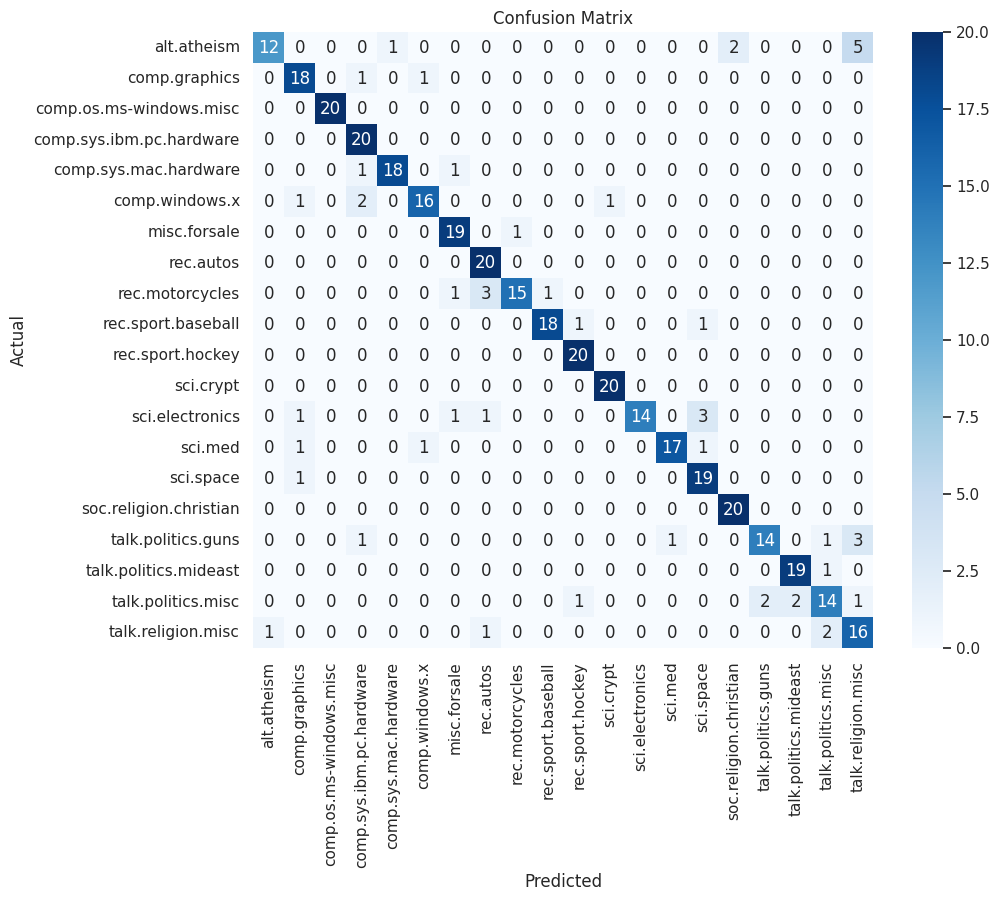

In [18]:
#  — Confusion matrix plot

cm = confusion_matrix(y_test, y_pred, labels=y.cat.categories)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y.cat.categories, yticklabels=y.cat.categories, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Top features per class (Naive Bayes)
# MultinomialNB stores log probabilities in model.feature_log_prob_
feature_names = vectorizer.get_feature_names_out()

for i, cls in enumerate(model.classes_):
    topn = np.argsort(model.feature_log_prob_[i])[-15:]  # top 15 features
    top_features = [feature_names[j] for j in topn][::-1]  # reverse to show highest first
    print(f"\nClass: {cls} | Top features: {', '.join(top_features)}")


Class: alt.atheism | Top features: edu, atheism, alt atheism, com, alt, sgi, sgi com, newsgroups alt, uk, cmu, cmu edu, caltech edu, caltech, sandvik, objective

Class: comp.graphics | Top features: graphics, edu, comp graphics, comp, graphics subject, cmu, cmu edu, newsgroups comp, graphics path, cs, au, com, tiff, news, de

Class: comp.os.ms-windows.misc | Top features: windows, os, ms, ms windows, comp os, os ms, edu, windows misc, comp, misc, dos, nt, file, cmu, cmu edu

Class: comp.sys.ibm.pc.hardware | Top features: edu, pc, ibm, ibm pc, sys ibm, pc hardware, hardware, comp sys, sys, comp, com, newsgroups comp, cmu edu, cmu, bus

Class: comp.sys.mac.hardware | Top features: mac, edu, sys mac, mac hardware, sys, comp sys, hardware, comp, cmu, cmu edu, newsgroups comp, apple, hardware subject, apr, news

Class: comp.windows.x | Top features: comp windows, windows, edu, comp, motif, com, window, newsgroups comp, cmu edu, cmu, windows path, ac, cs, mit, windows comp

Class: misc.for

In [20]:
#Inspect misclassified examples
# Reconstruct a small DataFrame for test set to inspect errors.
# Need to map indices from X_test back to original df. Simpler approach:
# Re-split original df keeping indices so we can inspect original text.

from sklearn.model_selection import train_test_split
df_temp = df.reset_index(drop=False)  # keep original index in column 'index'
X_full = vectorizer.transform(df_temp['clean_text'])
_, _, y_train_idx, y_test_idx = train_test_split(
    df_temp.index, df_temp['Labels'], test_size=0.2, random_state=RANDOM_STATE, stratify=df_temp['Labels']
)

In [23]:
df_temp = df.reset_index(drop=False)

In [26]:
# Split using those indices
train_idx, test_idx = train_test_split(
    df_temp.index,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=df_temp['Labels']
)




In [27]:
# Build dataframe with predictions
errors = df_temp.loc[test_idx].copy()
errors['true'] = y_test_full.values
errors['pred'] = y_pred_full

In [28]:
# Filter misclassified examples
mis = errors[errors['true'] != errors['pred']]

print("Number of misclassified examples:", mis.shape[0])
display(mis[['Data','clean_text','true','pred']].sample(min(6, mis.shape[0]), random_state=RANDOM_STATE))

Number of misclassified examples: 51


,Data,clean_text,true,pred
86,"Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53665 talk.religion.misc:84010 talk.origins:41039\nNewsgroups: alt.atheism,talk.religion.misc,talk.origins\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!darwin.sura.net!haven.umd.edu!uunet!timbuk.cray.c...",xref cantaloupe srv cs cmu edu alt atheism talk religion misc talk origins newsgroups alt atheism talk religion misc talk origins path cantaloupe srv cs cmu edu crabapple srv cs cmu edu fs ece cmu edu europa eng gtefsd com darwin sura net umd edu uunet timbuk cray com equalizer pats pats equaliz...,alt.atheism,talk.religion.misc
1282,"Xref: cantaloupe.srv.cs.cmu.edu rec.radio.amateur.misc:37484 sci.electronics:53628\nNewsgroups: rec.radio.amateur.misc,sci.electronics\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!zaphod.mps.ohio-state.edu!saimiri.primate....",xref cantaloupe srv cs cmu edu rec radio amateur misc sci electronics newsgroups rec radio amateur misc sci electronics path cantaloupe srv cs cmu edu crabapple srv cs cmu edu fs ece cmu edu europa eng gtefsd com howland reston ans net zaphod mps ohio state edu saimiri primate wisc edu usenet co...,sci.electronics,sci.space
874,Newsgroups: rec.motorcycles\nPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!darwin.sura.net!uvaarpa!maxwell!cds7k\nFrom: cds7k@Virginia.EDU (Christopher Douglas Saady)\nSubject: Re: Bikes And Contacts\nMessage-ID: <1993Apr21.113244.17668@Virginia.E...,newsgroups rec motorcycles path cantaloupe srv cs cmu edu crabapple srv cs cmu edu fs ece cmu edu europa eng gtefsd com darwin sura net uvaarpa maxwell cds k cds k virginia edu christopher douglas saady subject bikes contacts message id apr virginia edu organization university virginia reference...,rec.motorcycles,rec.autos
1361,"Xref: cantaloupe.srv.cs.cmu.edu misc.consumers:67746 sci.med:58938 rec.food.cooking:65284 sci.environment:29504\nNewsgroups: misc.consumers,sci.med,rec.food.cooking,sci.environment\nPath: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!spool.mu.edu!uwm.edu!lina...",xref cantaloupe srv cs cmu edu misc consumers sci med rec food cooking sci environment newsgroups misc consumers sci med rec food cooking sci environment path cantaloupe srv cs cmu edu das news harvard edu noc near net howland reston ans net spool mu edu uwm edu linac att att walter wind jchen j...,sci.med,sci.space
1231,"Xref: cantaloupe.srv.cs.cmu.edu rec.music.marketplace:4394 misc.forsale:74726 misc.wanted:30876 comp.music:12525 sci.electronics:52720 rec.music.makers.synth:4315\nNewsgroups: rec.music.marketplace,osu.for-sale,misc.forsale,misc.wanted,comp.music,sci.electronics,rec.music.makers.synth\nPath: can...",xref cantaloupe srv cs cmu edu rec music marketplace misc forsale misc wanted comp music sci electronics rec music makers synth newsgroups rec music marketplace osu sale misc forsale misc wanted comp music sci electronics rec music makers synth path cantaloupe srv cs cmu edu crabapple srv cs cmu...,sci.electronics,misc.forsale
1874,"Xref: cantaloupe.srv.cs.cmu.edu talk.politics.misc:178598 talk.religion.misc:83648 sci.skeptic:43296\nNewsgroups: talk.politics.misc,talk.religion.misc,sci.skeptic\nPath: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!zaphod.mps.ohio-state.edu!saimiri.primate....",xref cantaloupe srv cs cmu edu talk politics misc talk religion misc sci skeptic newsgroups talk politics misc talk religion misc sci skeptic path cantaloupe srv cs cmu edu das news harvard edu noc near net howland reston ans net zaphod mps ohio state edu saimiri primate wisc edu zazen doug cae ...,talk.politics.misc,talk.religion.misc


In [29]:
 #Cell 12 — Sentiment Analysis
# We will compute sentiment only on the original Data column as you requested.

sia = SentimentIntensityAnalyzer()

def vader_label(text, pos_thresh=0.05, neg_thresh=-0.05):
    if pd.isna(text) or str(text).strip()=="":
        return "Neutral"
    score = sia.polarity_scores(str(text))['compound']
    if score > pos_thresh:
        return "Positive"
    elif score < neg_thresh:
        return "Negative"
    else:
        return "Neutral"

def textblob_label(text, pos_thresh=0.05, neg_thresh=-0.05):
    if pd.isna(text) or str(text).strip()=="":
        return "Neutral"
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > pos_thresh:
        return "Positive"
    elif polarity < neg_thresh:
        return "Negative"
    else:
        return "Neutral"

In [30]:
# Apply to Data column
df['sentiment_vader'] = df['Data'].apply(vader_label)
df['sentiment_textblob'] = df['Data'].apply(textblob_label)


In [31]:
# Summary distributions
print("Overall VADER sentiment distribution:\n", df['sentiment_vader'].value_counts())
print("\nOverall TextBlob sentiment distribution:\n", df['sentiment_textblob'].value_counts())

Overall VADER sentiment distribution:
 sentiment_vader
Positive    1334
Negative     631
Neutral       35
Name: count, dtype: int64

Overall TextBlob sentiment distribution:
 sentiment_textblob
Positive    1192
Neutral      542
Negative     266
Name: count, dtype: int64


In [32]:
# Sentiment distribution across categories
# We'll show counts and percentages
sent_counts = df.groupby(['Labels','sentiment_vader']).size().unstack(fill_value=0)
sent_perc = sent_counts.div(sent_counts.sum(axis=1), axis=0) * 100

print("Counts by category and sentiment (VADER):")
display(sent_counts)
print("\nPercentages by category and sentiment (VADER):")
display(sent_perc.round(2))


Counts by category and sentiment (VADER):


sentiment_vader,Negative,Neutral,Positive
Labels,,,
alt.atheism,42,1,57
comp.graphics,13,4,83
comp.os.ms-windows.misc,24,2,74
comp.sys.ibm.pc.hardware,21,0,79
comp.sys.mac.hardware,24,3,73
comp.windows.x,20,2,78
misc.forsale,7,8,85
rec.autos,27,1,72
rec.motorcycles,30,2,68



Percentages by category and sentiment (VADER):


sentiment_vader,Negative,Neutral,Positive
Labels,,,
alt.atheism,42.0,1.0,57.0
comp.graphics,13.0,4.0,83.0
comp.os.ms-windows.misc,24.0,2.0,74.0
comp.sys.ibm.pc.hardware,21.0,0.0,79.0
comp.sys.mac.hardware,24.0,3.0,73.0
comp.windows.x,20.0,2.0,78.0
misc.forsale,7.0,8.0,85.0
rec.autos,27.0,1.0,72.0
rec.motorcycles,30.0,2.0,68.0


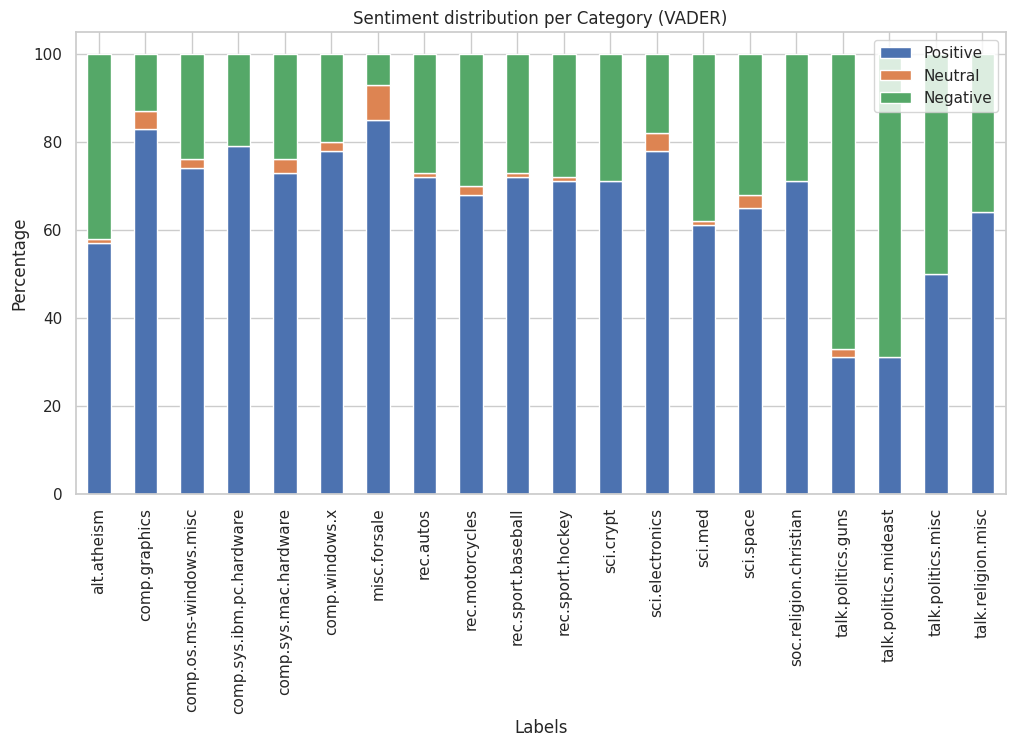

In [33]:
# Plot stacked percent bar chart
sent_perc[['Positive','Neutral','Negative']].plot(kind='bar', stacked=True, figsize=(12,6))
plt.ylabel('Percentage')
plt.title('Sentiment distribution per Category (VADER)')
plt.legend(loc='upper right')
plt.show()

In [34]:
# Save results & export for report
# Save dataframe with predictions and sentiment columns for downstream analysis/report.
# We'll also compute predicted_label for entire dataset (useful for report)
df['predicted_label'] = model.predict(vectorizer.transform(df['clean_text']))

OUT_PATH = '/content/blogs_analysis_results.csv'
df.to_csv(OUT_PATH, index=False)
print("Saved results to:", OUT_PATH)

Saved results to: /content/blogs_analysis_results.csv


In [38]:
# Short discussion template for your report
report_text = f"""
Report (brief):
---------------
1) Data Exploration:
   - Number of posts: {df.shape[0]}
   - Number of categories: {y.cat.categories.size}
   - Class distribution:
{df['Labels'].value_counts().to_string()}

2) Preprocessing:
   - Lowercased, removed URLs, punctuation & numbers, removed English stopwords.
   - Feature extraction: TF-IDF (unigrams + bigrams), max_features=5000.

3) Model:
   - Algorithm: Multinomial Naive Bayes (alpha=1.0)
   - Train/test split: 80/20 stratified.

4) Evaluation (on test set):
   - Accuracy: {acc:.4f}
   - Macro F1: {f1_macro:.4f}
   - Weighted F1: {f1_weight:.4f}
   - See confusion matrix and classification report in the notebook for per-class performance.

5) Sentiment:
   - Method: VADER (primary), TextBlob (secondary)
   - Overall sentiment distribution (VADER): {df['sentiment_vader'].value_counts().to_dict()}
   - Observations: (Add interpretation: e.g., which categories are more positive/negative; any surprising patterns.)

6) Challenges & next steps:
   - Potential issues: class imbalance, ambiguous multi-topic posts, domain-specific vocab.
   - Improvements: hyperparameter tuning, compare LogisticRegression/SVM, more data augmentation for minority classes, transformer-based sentiment models for improved sentiment accuracy.

"""
print(report_text)


Report (brief):
---------------
1) Data Exploration:
   - Number of posts: 2000
   - Number of categories: 20
   - Class distribution: 
Labels
alt.atheism                 100
comp.graphics               100
comp.os.ms-windows.misc     100
comp.sys.ibm.pc.hardware    100
comp.sys.mac.hardware       100
comp.windows.x              100
misc.forsale                100
rec.autos                   100
rec.motorcycles             100
rec.sport.baseball          100
rec.sport.hockey            100
sci.crypt                   100
sci.electronics             100
sci.med                     100
sci.space                   100
soc.religion.christian      100
talk.politics.guns          100
talk.politics.mideast       100
talk.politics.misc          100
talk.religion.misc          100

2) Preprocessing:
   - Lowercased, removed URLs, punctuation & numbers, removed English stopwords.
   - Feature extraction: TF-IDF (unigrams + bigrams), max_features=5000.

3) Model:
   - Algorithm: Multinomial Naiv